<a href="https://colab.research.google.com/github/Alokik-29/Project_1/blob/main/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
#Install dependencies
!pip install librosa soundfile matplotlib numpy

In [42]:
import os,sys,random,math
from pathlib import Path
import numpy as np
import pandas as pd
import librosa,librosa.display
import torchaudio
import torch
import matplotlib.pyplot as plt
from IPython.display  import Audio,display
from sklearn.model_selection import train_test_split

#reproducibility
SEED=42
random.seed(SEED)
np.random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#mtplotlib defaults
plt.rcParams["figure.figsize"]=(10,4)
plt.rcParams["axes.grid"]=True

print("Librosa:", librosa.__version__)
print("Torchaudio:", torchaudio.__version__)


Librosa: 0.11.0
Torchaudio: 2.8.0+cu126


In [43]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ravdess-emotional-speech-audio


In [44]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")

print("Path to dataset files:", path)
dataset_path = path

Path to dataset files: /kaggle/input/ravdess-emotional-speech-audio


In [45]:
#emotion labell mapping from RAVDESS dataset
emotion_map={
    "01":"neutral",
    "02":"calm",
    "03":"happy",
    "04":"sad",
    "05":"angry",
    "06":"fearful",
    "07":"disgust",
    "08":"surprised"
}

In [46]:
#getting all audio file path
audio_files=list(Path(dataset_path).rglob("*.wav"))

#extracting labels from file name
labels=[]
for file in audio_files:

    filename = file.name  # just the filename, e.g., "03-01-01-01-01-01-01.wav"
    emotion_code = filename.split("-")[2]  # third part indicates emotion
    labels.append(emotion_map[emotion_code])

df=pd.DataFrame({
    "file_path":audio_files,
    "label":labels
})
# Keep only valid labels
valid_labels = list(emotion_map.values())
df = df[df['label'].isin(valid_labels)].reset_index(drop=True)

print(f"Total samples: {len(df)}")
print(df['label'].value_counts())

df=df.sample(frac=1,random_state=SEED).reset_index(drop=True)
df.head()

Total samples: 2880
label
surprised    384
disgust      384
fearful      384
sad          384
happy        384
calm         384
angry        384
neutral      192
Name: count, dtype: int64


,file_path,label
0,/kaggle/input/ravdess-emotional-speech-audio/A...,calm
1,/kaggle/input/ravdess-emotional-speech-audio/a...,fearful
2,/kaggle/input/ravdess-emotional-speech-audio/a...,sad
3,/kaggle/input/ravdess-emotional-speech-audio/a...,disgust
4,/kaggle/input/ravdess-emotional-speech-audio/A...,sad


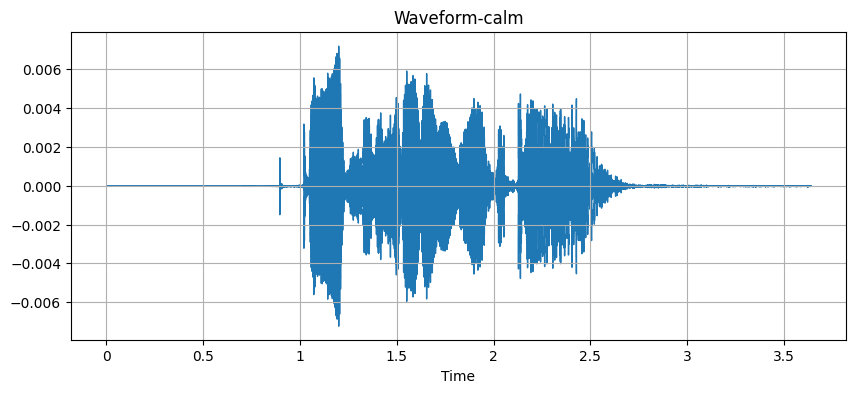

In [47]:
#pick a random sample
if not df.empty:
  sample_file=df['file_path'][0]
  sample_label=df['label'][0]

  #displaay audio player
  display(Audio(sample_file))

  #load waveform
  y,sr=librosa.load(sample_file,sr=16000)
  y = np.expand_dims(y, axis=0)
  plt.figure()
  librosa.display.waveshow(y,sr=sr)
  plt.title(f"Waveform-{sample_label}")
  plt.show()
else:
  print("DataFrame is empty, cannot display a sample.")

In [48]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchaudio

#Define a transform function to convert audio to Mel Spectrogram
def mel_spectrogram_transform(y,sr,n_mels=64,n_fft=1024,hop_length=512):
  # Convert numpy array to torch tensor
  waveform=torch.tensor(y).unsqueeze(0)
  mel_spec=torchaudio.transforms.MelSpectrogram(
      sample_rate=sr,
      n_fft=n_fft,
      hop_length=hop_length,
      n_mels=n_mels
  )(waveform)
  # Convert power spectrogram to log scale (dB)
  mel_spec=torchaudio.transforms.AmplitudeToDB()(mel_spec)
  return mel_spec


In [49]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df['label'])

print(f"Training samples: {len(train_df)}")
print(f"Testing samples: {len(test_df)}")

Training samples: 2304
Testing samples: 576


In [50]:
from torch.utils.data import Dataset, DataLoader
import torch
import librosa
from transformers import ASTForAudioClassification, ASTFeatureExtractor
import numpy as np

# Custom Dataset
class RAVDESSDataset(Dataset):
    def __init__(self, df, target_sr=16000):
        self.df = df
        self.target_sr = target_sr
        self.label_list = list(emotion_map.values())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = str(self.df.iloc[idx]['file_path'])
        label = self.df.iloc[idx]['label']

        if label not in self.label_list:
            raise ValueError(f"Invalid label found: {label}")

        # Load waveform at 16kHz
        y, sr = librosa.load(file_path, sr=self.target_sr)
        y = y.astype(np.float32)

        # Return raw waveform and label index
        label_idx = self.label_list.index(label)
        return y, label_idx

# Instantiate Dataset and DataLoader
train_dataset = RAVDESSDataset(train_df)
test_dataset = RAVDESSDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Load AST model and feature extractor
feature_extractor = ASTFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
model = ASTForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

# Replace classifier for 8 emotions
import torch.nn as nn
num_labels = len(emotion_map)
model.classifier = nn.Linear(model.config.hidden_size, num_labels)
model.to(device)


ASTForAudioClassification(
  (audio_spectrogram_transformer): ASTModel(
    (embeddings): ASTEmbeddings(
      (patch_embeddings): ASTPatchEmbeddings(
        (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ASTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ASTLayer(
          (attention): ASTAttention(
            (attention): ASTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ASTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ASTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=T

In [51]:
print(model)

ASTForAudioClassification(
  (audio_spectrogram_transformer): ASTModel(
    (embeddings): ASTEmbeddings(
      (patch_embeddings): ASTPatchEmbeddings(
        (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ASTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ASTLayer(
          (attention): ASTAttention(
            (attention): ASTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ASTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ASTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=T

In [52]:
from sklearn.model_selection import train_test_split
from transformers import ASTForAudioClassification, ASTFeatureExtractor

def collate_fn(batch):
    waveforms, labels = zip(*batch)

    # Convert all waveforms to tensors if they aren't already
    waveforms = [w if isinstance(w, torch.Tensor) else torch.tensor(w) for w in waveforms]

    # Pad to max length in the batch
    max_len = max([w.shape[0] for w in waveforms])
    padded_waveforms = [torch.nn.functional.pad(w, (0, max_len - w.shape[0])) for w in waveforms]

    waveforms_tensor = torch.stack(padded_waveforms)
    labels_tensor = torch.tensor(labels)

    return waveforms_tensor, labels_tensor




# Instantiate Dataset and DataLoader
train_dataset = RAVDESSDataset(train_df)
test_dataset = RAVDESSDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

# Load AST model and feature extractor
feature_extractor = ASTFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
model = ASTForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

# Replace classifier for 8 emotions
import torch.nn as nn
num_labels = len(emotion_map)
model.classifier = nn.Linear(model.config.hidden_size, num_labels)
model.to(device)

# Freeze everything first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze classifier
for param in model.classifier.parameters():
    param.requires_grad = True

# Unfreeze last 2 encoder layers
for i in range(-2, 0):
    for param in model.audio_spectrogram_transformer.encoder.layer[i].parameters():
        param.requires_grad = True



In [53]:
num_epochs = 10
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
criterion = nn.CrossEntropyLoss()

model.train()

for epoch in range(num_epochs):
    running_loss = 0
    correct = 0
    total = 0

    for waveforms, labels in train_loader:
        labels = labels.to(device)

        # Convert raw waveforms to AST input in batch
        inputs_list = []
        for w in waveforms:
            inp = feature_extractor(w.cpu().numpy(), sampling_rate=16000, return_tensors="pt")["input_values"]
            inputs_list.append(inp)
        inputs = torch.cat(inputs_list, dim=0).to(device)

        optimizer.zero_grad()
        outputs = model(inputs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {running_loss/len(train_loader):.4f} | Accuracy: {100*correct/total:.2f}%")

Epoch [1/10] | Loss: 1.4836 | Accuracy: 43.79%
Epoch [2/10] | Loss: 0.8827 | Accuracy: 66.97%
Epoch [3/10] | Loss: 0.5466 | Accuracy: 79.86%
Epoch [4/10] | Loss: 0.3063 | Accuracy: 88.67%
Epoch [5/10] | Loss: 0.1874 | Accuracy: 93.49%
Epoch [6/10] | Loss: 0.0906 | Accuracy: 97.22%
Epoch [7/10] | Loss: 0.0881 | Accuracy: 97.01%
Epoch [8/10] | Loss: 0.0346 | Accuracy: 99.00%
Epoch [9/10] | Loss: 0.0089 | Accuracy: 99.78%
Epoch [10/10] | Loss: 0.0012 | Accuracy: 100.00%
